## Altair with simple, sample data

- [Vega-Lite site](https://vega.github.io/vega-lite/)
- [Vega-Lite documentation](https://vega.github.io/vega-lite/docs/)
- [Altair documentation](https://altair-viz.github.io/index.html)
- [Vega-Lite 2.0 Medium article](https://medium.com/@uwdata/introducing-vega-lite-2-0-de6661c12d58)
- [Vega-Lite 2.0 OpenVisConf 2017 talk](https://www.youtube.com/watch?v=9uaHRWj04D4)
- [About the Vega project](https://vega.github.io/vega/about/)

Inspired by a [Nature Methods article](https://www.nature.com/articles/nmeth.2807)

In [1]:
import pandas as pd
import altair as alt

### Load in sample data

In [2]:
df_orig = pd.read_csv('NatureBarValues.csv')

In [3]:
df_orig

,Item,Category 1,Category 2,Category 3,Category 4,Category 5
0,Item 1,6,29,18,30,7
1,Item 2,8,27,17,13,11
2,Item 3,10,21,16,4,19
3,Item 4,20,17,16,9,7
4,Item 5,23,5,15,19,2


### Make data "tidy"

See my previous *Tidy Data in Python with JupyterLab*
[repository](https://github.com/emonson/tidy-data-python) and [video](https://library.capture.duke.edu/Panopto/Pages/Viewer.aspx?id=d8a3efe2-48d7-4505-acd3-a943013c2442)

In [4]:
df = df_orig.melt(id_vars=["Item"],var_name="Category")
df.head(10)

,Item,Category,value
0,Item 1,Category 1,6
1,Item 2,Category 1,8
2,Item 3,Category 1,10
3,Item 4,Category 1,20
4,Item 5,Category 1,23
5,Item 1,Category 2,29
6,Item 2,Category 2,27
7,Item 3,Category 2,21
8,Item 4,Category 2,17
9,Item 5,Category 2,5


### Heatmap

[Vega-Lite color schemes](https://vega.github.io/vega/docs/schemes/)

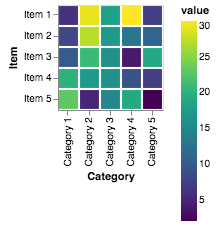

In [5]:
alt.Chart(df).mark_rect().encode(
    x = 'Category',
    y = 'Item',
    color = 'value'
)

### Vega-Lite specification

- [Vega-Lite site](https://vega.github.io/vega-lite/)
- [Medium article on Vega-Lite adoption](https://medium.com/@robin.linacre/why-im-backing-vega-lite-as-our-default-tool-for-data-visualisation-51c20970df39)

In [6]:
heatmap = alt.Chart(df).mark_rect().encode(
    x = 'Category',
    y = 'Item',
    color = 'value'
)
heatmap.to_dict()

{'config': {'view': {'width': 400, 'height': 300}},
 'data': {'name': 'data-dcc63c1bd6179d79fcae39778c52b169'},
 'mark': 'rect',
 'encoding': {'color': {'type': 'quantitative', 'field': 'value'},
  'x': {'type': 'nominal', 'field': 'Category'},
  'y': {'type': 'nominal', 'field': 'Item'}},
 '$schema': 'https://vega.github.io/schema/vega-lite/v2.6.0.json',
 'datasets': {'data-dcc63c1bd6179d79fcae39778c52b169': [{'Item': 'Item 1',
    'Category': 'Category 1',
    'value': 6},
   {'Item': 'Item 2', 'Category': 'Category 1', 'value': 8},
   {'Item': 'Item 3', 'Category': 'Category 1', 'value': 10},
   {'Item': 'Item 4', 'Category': 'Category 1', 'value': 20},
   {'Item': 'Item 5', 'Category': 'Category 1', 'value': 23},
   {'Item': 'Item 1', 'Category': 'Category 2', 'value': 29},
   {'Item': 'Item 2', 'Category': 'Category 2', 'value': 27},
   {'Item': 'Item 3', 'Category': 'Category 2', 'value': 21},
   {'Item': 'Item 4', 'Category': 'Category 2', 'value': 17},
   {'Item': 'Item 5', 'Ca

#### All data still included, even with a filter applied

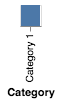

In [7]:
alt.Chart(df).mark_rect().encode(
    x = 'Category'
).transform_filter(
    "datum.Category == 'Category 1'"
)

In [8]:
heatmap = alt.Chart(df).mark_rect().encode(
    x = 'Category'
).transform_filter(
    "datum.Category == 'Category 1'"
)
heatmap.to_dict()

{'config': {'view': {'width': 400, 'height': 300}},
 'data': {'name': 'data-dcc63c1bd6179d79fcae39778c52b169'},
 'mark': 'rect',
 'encoding': {'x': {'type': 'nominal', 'field': 'Category'}},
 'transform': [{'filter': "datum.Category == 'Category 1'"}],
 '$schema': 'https://vega.github.io/schema/vega-lite/v2.6.0.json',
 'datasets': {'data-dcc63c1bd6179d79fcae39778c52b169': [{'Item': 'Item 1',
    'Category': 'Category 1',
    'value': 6},
   {'Item': 'Item 2', 'Category': 'Category 1', 'value': 8},
   {'Item': 'Item 3', 'Category': 'Category 1', 'value': 10},
   {'Item': 'Item 4', 'Category': 'Category 1', 'value': 20},
   {'Item': 'Item 5', 'Category': 'Category 1', 'value': 23},
   {'Item': 'Item 1', 'Category': 'Category 2', 'value': 29},
   {'Item': 'Item 2', 'Category': 'Category 2', 'value': 27},
   {'Item': 'Item 3', 'Category': 'Category 2', 'value': 21},
   {'Item': 'Item 4', 'Category': 'Category 2', 'value': 17},
   {'Item': 'Item 5', 'Category': 'Category 2', 'value': 5},
  

## MaxRowsError

Can take off limit for number of rows, but that's not a great idea because the notebook will have a Vega-Lite JSON specification (text) embedded for every output pane, which also includes the data, so you end up with huge notebooks!

Instead, we can specify that the outputs should just refer to a JSON file on your local drive and load in the data from there for each plot.

See the [Altair tutorial notebook](https://github.com/altair-viz/altair-tutorial/blob/master/notebooks/03-Binning-and-aggregation.ipynb) `03-Binning-and-aggregation` for more details.

In [9]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

### Now data is just referenced from JSON in Vega-Lite specification

In [10]:
heatmap.to_dict()

{'config': {'view': {'width': 400, 'height': 300}},
 'data': {'url': 'altair-data-734e125f330dd2d43ae418168a63d485.json',
  'format': {'type': 'json'}},
 'mark': 'rect',
 'encoding': {'x': {'type': 'nominal', 'field': 'Category'}},
 'transform': [{'filter': "datum.Category == 'Category 1'"}],
 '$schema': 'https://vega.github.io/schema/vega-lite/v2.6.0.json'}

## Other visual encodings

### Rect with size variation

Note that now we're specifying the variable types, in this case so Altair will give us a categorical (nominal) color scheme instead of ordinal.

[Encoding data types](https://altair-viz.github.io/user_guide/encoding.html#encoding-data-types)

|Data Type|Shorthand Code|Description
|---|---|---
|quantitative|Q|a continuous real-valued quantity
|ordinal|O|a discrete ordered quantity
|nominal|N|a discrete unordered category
|temporal|T|a time or date value


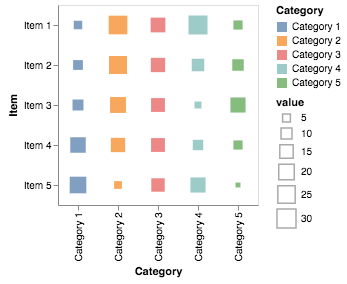

In [11]:
alt.Chart(df).mark_square().encode(
    x = 'Category:O',
    y = 'Item:O',
    color = 'Category:N',
    size = 'value:Q'
).properties(
    width = 200,
    height = 200
)

### Comparing summed levels with Stacked bar

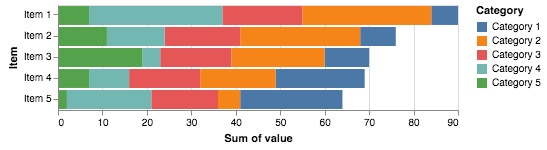

In [12]:
alt.Chart(df).mark_bar().encode(
    x = 'sum(value):Q',
    y = 'Item:O',
    color = 'Category:N'
)

### Comparing within item bars

If we want people to be able to make comparisons across categories within each item, say whether Category 2 or 4 is larger in Item 1, we need to give them a common baseline.

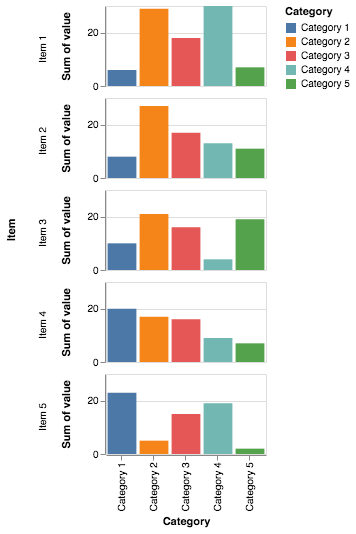

In [13]:
alt.Chart(df).mark_bar().encode(
    x = 'Category:O',
    y = 'sum(value):Q',
    color = 'Category:N'
).properties(
    width = 160,
    height = 80
).facet(
    row='Item:O'
)

### Dot plot for the same comparison

Another way to give the categories within an item a common baseline is to make a dot plot. This works well as long as there isn't too much value overlap.

*Note: Default is grid lines on continuous scale axes and not on nominal or ordinal, but I want lines along each item to help guide the eye. [Top-level configuration docs](https://altair-viz.github.io/user_guide/configuration.html)*

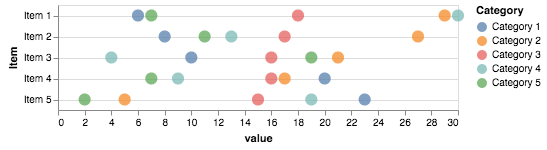

In [14]:
alt.Chart(df).mark_circle(size=150).encode(
    x = 'value:Q',
    y = 'Item:O',
    color = 'Category:N'
).configure_axisY(grid=True).configure_axisX(grid=False)

### Back to the stacked bar

What if we wanted to compare the lengths within a category? We're bad at comparing bar sizes that don't have common baselines.

*Note that the bar color stacking puts the first legend item furthest right, so here we've added an "order"*

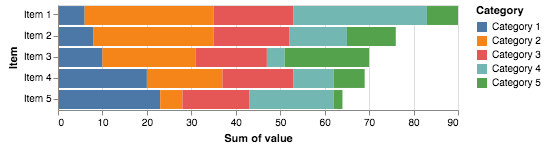

In [15]:
alt.Chart(df).mark_bar().encode(
    x = 'sum(value):Q',
    y = 'Item:O',
    color = 'Category:N',
    order = alt.Order('Category:O', sort='ascending'),
    tooltip=['Item','Category','sum(value)']
)

### Comparing within category bars

The common baseline again gives us easy comparisons within a category

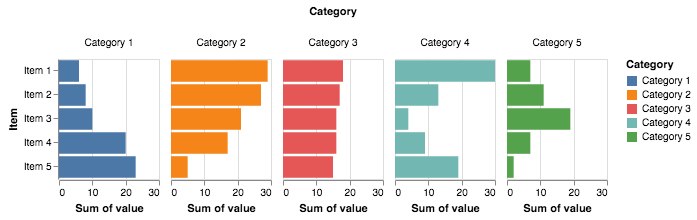

In [16]:
alt.Chart(df).mark_bar().encode(
    x = 'sum(value):Q',
    y = 'Item:O',
    color = 'Category:N'
).properties(
    width = 100,
    height = 120
).facet(
    column='Category:O'
)

#### Equivalent faceting by putting row or column in encode()

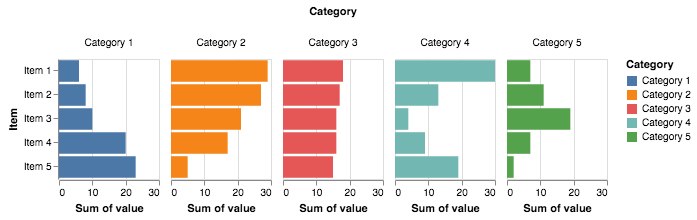

In [17]:
alt.Chart(df).mark_bar().encode(
    x = 'sum(value):Q',
    y = 'Item:O',
    color = 'Category:N',
    column = 'Category:O'
).properties(
    width = 100,
    height = 120
)

## Saving to files

In [18]:
bars = alt.Chart(df).mark_bar().encode(
    x = 'sum(value):Q',
    y = 'Item:O',
    color = 'Category:N'
)

In [19]:
bars.save('stacked_bars.html')
bars.save('stacked_bars.json')

### SVG and PNG require Selenium

You can always render your visualization in the notebook and use the button to render to SVG or PNG. This method uses the web browswer you're using for your notebook to render to the file. 

If you want to render an SVG or PNG as an image from a command, without displaying it in a notebook or web page first, you need to have the Python module selenium installed. Selenium is a "headless" browser, which is like creating a web page in code with no visual display.

*This will probably give you an error on these machines.*

In [ ]:
bars.save('stacked_bars.svg')
bars.save('stacked_bars.png')